# Time series classification

An example on [BasicMotions](https://www.timeseriesclassification.com/description.php?Dataset=BasicMotions) dataset

In [1]:
# Plotting and data loading imports used in this notebook
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import socket
from icecream import install
install()

from aeon.datasets import load_basic_motions

warnings.filterwarnings("ignore")


def basic_motions_to_dataframe(split):
    motions, motions_labels = load_basic_motions(split=split)
    # print(f"Motions type {type(motions)} of shape {motions.shape} - {motions_labels.shape}")
    rows = []
    for subject_id in range(motions.shape[0]):
        for step in range(motions.shape[2]):
            row = motions[subject_id, :, step].tolist() + [step, subject_id, motions_labels[subject_id]]
            rows.append(row)
    return pd.DataFrame(
        data=rows,
        columns=[ f"feature_{i}" for i in range(motions.shape[1])] + ['time_idx', 'subject', 'motion']
    )

train_df = basic_motions_to_dataframe(split='train')
VAL_SUBJECTS = [0, 10, 20, 39]
val_df = train_df[train_df['subject'].isin(VAL_SUBJECTS)]
train_df = train_df[~train_df['subject'].isin(VAL_SUBJECTS)]
test_df = basic_motions_to_dataframe(split='test')

FEATURES = train_df.columns.to_list()[:-3]
TARGETS = ['motion']
group_ids = ['subject', 'motion']
# group_ids = ['subject']

for target in TARGETS:
    train_df[target] = train_df[target].astype('category')
    test_df[target] = test_df[target].astype('category')
    val_df[target]  = val_df[target].astype('category')
ic(train_df.shape, val_df.shape, test_df.shape)

ic| train_df.shape: (3600, 9)
    val_df.shape: (400, 9)
    test_df.shape: (4000, 9)


((3600, 9), (400, 9), (4000, 9))

## Parameters

In [2]:
model_name = "lstm" # "graphic", "eran", "lstm"
simulate_multi_rate = False

## Simulate Multiple Sampling Rates

In [3]:
import numpy as np
def simulate_multiple_sampling_rate(df: pd.DataFrame, rates, time_idx, group_ids):
    df = df.sort_values(by=time_idx)
    g = df.groupby(by=group_ids)
    groups = []
    for name, group_df in g:
        for col, rate in rates.items():
            mask = [False] * len(group_df)
            for i in range(len(mask)):
                if (i+1) % rate == 0:
                    mask[i] = True
            group_df[col][mask] = np.NaN
            groups.append(group_df)
    return pd.concat(groups, axis=0)
if simulate_multi_rate:
    rates = {
        # 'feature_0': 1,
        'feature_1': 2,
        'feature_2': 3,
        # 'feature_3': 1,
        # 'feature_4': 5,
        # 'feature_5': 1,
    }
    train_df = simulate_multiple_sampling_rate(train_df, rates, time_idx='time_idx', group_ids=group_ids)
    val_df = simulate_multiple_sampling_rate(val_df, rates, time_idx='time_idx', group_ids=group_ids)
    test_df = simulate_multiple_sampling_rate(test_df, rates, time_idx='time_idx', group_ids=group_ids)


In [4]:
train_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,time_idx,subject,motion
100,0.377751,-0.610850,-0.147376,-0.103872,-0.109198,-0.037287,0,1,standing
101,0.377751,-0.610850,-0.147376,-0.103872,-0.109198,-0.037287,1,1,standing
102,2.952965,0.970717,-5.962515,-7.593275,-0.697804,-2.865789,2,1,standing
103,4.310925,-1.625661,-1.898794,-5.345389,0.402169,-4.176168,3,1,standing
104,3.256906,-6.969257,-2.730436,-2.743274,0.615239,-3.417107,4,1,standing
...,...,...,...,...,...,...,...,...,...
3895,0.685694,-2.105519,1.165885,0.261010,-0.793685,0.013317,95,38,badminton
3896,1.015222,-2.411690,0.087346,-0.058594,-0.697804,0.023970,96,38,badminton
3897,0.873364,-2.683228,0.555119,0.431466,-0.617902,0.319605,97,38,badminton
3898,-0.005607,-2.185891,1.224647,1.102636,-1.273092,0.977458,98,38,badminton


## Construct TimeseriesDataset

In [5]:
import torch
from icecream import install
install()

from united.data import SensorTimeSeriesDataset
from united.data import TimeSeriesDataset

sensors = list(train_df.columns)[:6]
print(sensors)

if model_name in ["graphic", "eran"]:
    train_dataset = SensorTimeSeriesDataset(
        data=train_df,
        sensors=sensors,
        group_ids=group_ids,
        time_idx='time_idx',
        min_encoder_length=100,
        max_encoder_length=100,
        min_decoder_length=0,
        max_decoder_length=0,
        encoder_variables=FEATURES,
        decoder_variables=[],
        targets=TARGETS,
        training=True,
        allow_missing_time_steps=True if simulate_multi_rate else False,
        imputers='tryhard' if simulate_multi_rate else None,
    )
    val_dataset = SensorTimeSeriesDataset.from_dataset(train_dataset, val_df, training=False)
    test_dataset = SensorTimeSeriesDataset.from_dataset(train_dataset, test_df, training=False)
else:
    train_dataset = TimeSeriesDataset(
        data=train_df,
        group_ids=group_ids,
        time_idx='time_idx',
        min_encoder_length=100,
        max_encoder_length=100,
        min_decoder_length=0,
        max_decoder_length=0,
        encoder_variables=FEATURES,
        decoder_variables=[],
        targets=TARGETS,
        training=True,
        allow_missing_time_steps=True,
        imputers='tryhard',
    )
    val_dataset = TimeSeriesDataset.from_dataset(train_dataset, val_df, training=False)
    test_dataset = TimeSeriesDataset.from_dataset(train_dataset, test_df, training=False)

batch_size = 4
train_loader    = train_dataset.to_dataloader(batch_size=batch_size, num_workers=0)
val_loader      = val_dataset.to_dataloader(batch_size=batch_size)
test_loader     = test_dataset.to_dataloader(batch_size=batch_size)

it_ = iter(train_loader)

ic(len(train_dataset), len(val_dataset), len(test_dataset))
ic(len(train_loader), len(val_loader), len(test_loader))


['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']


Indexing - step 1/2: 100%|██████████| 36/36 [00:00<00:00, 52247.39it/s]


Finished Indexing in 0.34(s)
Missing time steps:  0.00%(0/3600)
Preprocessing ...
Done


Indexing - step 1/2: 100%|██████████| 4/4 [00:00<00:00, 28435.96it/s]


Finished Indexing in 0.07(s)
Missing time steps:  0.00%(0/400)
Preprocessing ...
Done


Indexing - step 1/2: 100%|██████████| 40/40 [00:00<00:00, 115386.63it/s]


Finished Indexing in 0.47(s)
Missing time steps:  0.00%(0/4000)
Preprocessing ...
Done


ic| len(train_dataset): 36, len(val_dataset): 4, len(test_dataset): 40
ic| len(train_loader): 9, len(val_loader): 1, len(test_loader): 10


(9, 1, 10)

In [6]:
from united.models.classification import GraphICClassifier, EranClassifier, LSTMClassifier

if model_name == "graphic":
    model = GraphICClassifier.from_dataset(
        dataset=train_dataset,
    )
elif model_name == "eran":
    model = EranClassifier.from_dataset(train_dataset)
elif model_name == "lstm":
    model = LSTMClassifier.from_dataset(train_dataset)
else:
    raise ValueError(f"Unknown {model_name} model name")
model

<LSTMClassifier>(Params: {'group_ids': ['subject', 'motion'], 'time_idx': 'time_idx', 'min_encoder_length': 100, 'max_encoder_length': 100, 'min_decoder_length': 0, 'max_decoder_length': 0, 'encoder_variables': ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], 'decoder_variables': [], 'targets': ['motion'], 'static_variables': [], 'training': True, 'random_length': True, 'scalers': {'feature_0': StandardScaler(), 'feature_4': StandardScaler(), 'feature_3': StandardScaler(), 'feature_5': StandardScaler(), 'feature_1': StandardScaler(), 'feature_2': StandardScaler()}, 'target_normalizers': {'motion': LabelEncoder()}, 'imputers': {'feature_0': TryHardImputer(), 'feature_4': TryHardImputer(), 'feature_3': TryHardImputer(), 'feature_5': TryHardImputer(), 'feature_1': TryHardImputer(), 'feature_2': TryHardImputer()}, 'add_na': False, 'ignore_na': False, 'allow_missing_time_steps': True, 'unknown_value': nan, 'non_overlapped_windows': False, 'return_missing_mask'

In [7]:
x, y = next(it_)
for name, val in x.items():
    print(name, val.shape)
for name, val in y.items():
    print(name, val.shape)
y_pred = model(x)
y = model.construct_output(y)
y = model.tensor_to_predictions(y)
lengths = model.get_sequence_lengths(x)
for name, val in y_pred.items():
    print(name, val.shape)

model.compute_loss(y_pred, y, lengths)   

encoder torch.Size([4, 100, 6])
encoder_lengths torch.Size([4])
decoder torch.Size([4, 0, 0])
decoder_lengths torch.Size([4])
encoder torch.Size([4, 100, 1])
decoder torch.Size([4, 0, 1])
motion torch.Size([4, 1, 4])


tensor(1.4000, grad_fn=<DivBackward0>)

## Training

In [8]:
from lightning import Trainer
import lightning.pytorch as pl 
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
pl.seed_everything(42)
max_epochs = 150
early_stoping_callback = EarlyStopping(
    monitor='val/loss', 
    min_delta=1e-5, 
    patience=max_epochs//5, 
    verbose=False, 
    mode='min'
)
model_checkpoint_callback = ModelCheckpoint(
    monitor='val/loss', 
    mode='min', 
    save_last=True, 
    # save_top_k=1
)
lr_logger = LearningRateMonitor()
log_dir = f'runs/{model_name}/prod'
tb_logger = TensorBoardLogger(log_dir)

trainer = Trainer(
    max_epochs=max_epochs,
    enable_model_summary=True,
    callbacks=[
        lr_logger, 
        early_stoping_callback, 
        model_checkpoint_callback
    ],
    logger=tb_logger,
    gradient_clip_val=5.,
)
trainer.fit(
    model=model, 
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)
trainer.test(
    model,
    ckpt_path='best',
    dataloaders=test_loader,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | embeddings | ModuleDict | 0     
1 | lstm       | LSTM       | 270 K 
2 | predictors | ModuleDict | 1.0 K 
------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.085     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at runs/lstm/prod/lightning_logs/version_39/checkpoints/epoch=69-step=630.ckpt
Loaded model weights from the checkpoint at runs/lstm/prod/lightning_logs/version_39/checkpoints/epoch=69-step=630.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ALL/test/accuracy     │            0.9            │
│       ALL/test/auc        │    0.9983333333333334     │
│   ALL/test/bal_accuracy   │    0.8999999999999999     │
│         hp_metric         │    0.2533118724822998     │
│   motion/test/accuracy    │            0.9            │
│      motion/test/auc      │    0.9983333333333334     │
│ motion/test/bal_accuracy  │    0.8999999999999999     │
│     motion/test/loss/     │    0.2533118724822998     │
│         test/loss         │    0.2533118724822998     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.2533118724822998,
  'motion/test/loss/': 0.2533118724822998,
  'hp_metric': 0.2533118724822998,
  'motion/test/auc': 0.9983333333333334,
  'motion/test/accuracy': 0.9,
  'motion/test/bal_accuracy': 0.8999999999999999,
  'ALL/test/auc': 0.9983333333333334,
  'ALL/test/accuracy': 0.9,
  'ALL/test/bal_accuracy': 0.8999999999999999}]

## Load and Inference with trained models

In [9]:
import torch
from united.models.classification import GraphICClassifier, EranClassifier, LSTMClassifier
from united.data import SensorTimeSeriesDataset

if model_name == "graphic":
    model_path = "runs/eran/prod/lightning_logs/version_0/checkpoints/epoch=11-step=108.ckpt"
    model = GraphICClassifier.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
elif model_name == "eran":
    model_path = "runs/eran/prod/lightning_logs/version_0/checkpoints/epoch=11-step=108.ckpt"
    model = EranClassifier.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
elif model_name == "lstm":
    model_path = "runs/lstm/prod/lightning_logs/version_33/checkpoints/epoch=120-step=1089.ckpt"
    model = LSTMClassifier.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
else:
    raise ValueError(f"Unknown {model_name} model name")




model.eval()
print(model.dataset_params)
if model_name in ["graphic", "eran"]:
    test_dataset = SensorTimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)
elif model_name in ["lstm"]:
    test_dataset = TimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)

batch_size = 1
num_workers = 0
    
test_loader     = test_dataset.to_dataloader(batch_size=batch_size, shuffle=True)

it_ = iter(test_loader)

ic(len(test_dataset))
ic(len(test_loader))

{'group_ids': ['subject'], 'time_idx': 'time_idx', 'min_encoder_length': 100, 'max_encoder_length': 100, 'min_decoder_length': 0, 'max_decoder_length': 0, 'encoder_variables': ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], 'decoder_variables': [], 'targets': ['motion'], 'static_variables': [], 'training': True, 'random_length': True, 'scalers': {'feature_5': StandardScaler(), 'feature_1': StandardScaler(), 'feature_2': StandardScaler(), 'feature_0': StandardScaler(), 'feature_3': StandardScaler(), 'feature_4': StandardScaler()}, 'target_normalizers': {'motion': LabelEncoder()}, 'imputers': {'feature_5': TryHardImputer(), 'feature_1': TryHardImputer(), 'feature_2': TryHardImputer(), 'feature_0': TryHardImputer(), 'feature_3': TryHardImputer(), 'feature_4': TryHardImputer()}, 'add_na': False, 'ignore_na': False, 'allow_missing_time_steps': True, 'unknown_value': nan, 'non_overlapped_windows': False, 'return_missing_mask': False}


Indexing - step 2/2:   0%|          | 0/40 [00:00<?, ?it/s]

Indexing - step 1/2: 100%|██████████| 40/40 [00:00<00:00, 85423.71it/s]


Finished Indexing in 0.41(s)
Missing time steps:  0.00%(0/4000)
Preprocessing ...
Done


ic| len(test_dataset): 40
ic| len(test_loader): 40


40

In [10]:
x, y = next(it_)
predictions = model.predict(x)

y = model.construct_output(y)
true_predictions = model.tensor_to_predictions(y)
ic(predictions, true_predictions)

ic| predictions:

 {'motion': tensor([[2]])}
    true_predictions: {'motion': tensor([[2.]])}


({'motion': tensor([[2]])}, {'motion': tensor([[2.]])})

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   feature_0  4000 non-null   float64 
 1   feature_1  4000 non-null   float64 
 2   feature_2  4000 non-null   float64 
 3   feature_3  4000 non-null   float64 
 4   feature_4  4000 non-null   float64 
 5   feature_5  4000 non-null   float64 
 6   time_idx   4000 non-null   int64   
 7   subject    4000 non-null   int64   
 8   motion     4000 non-null   category
dtypes: category(1), float64(6), int64(2)
memory usage: 254.2 KB


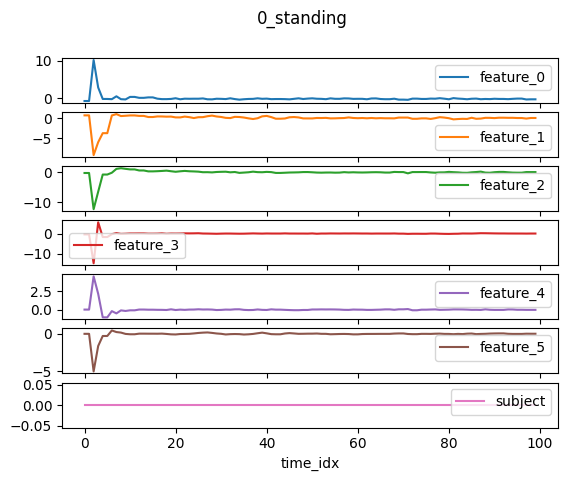

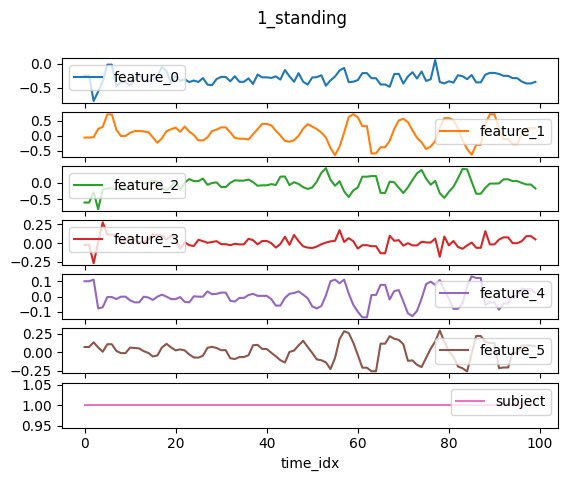

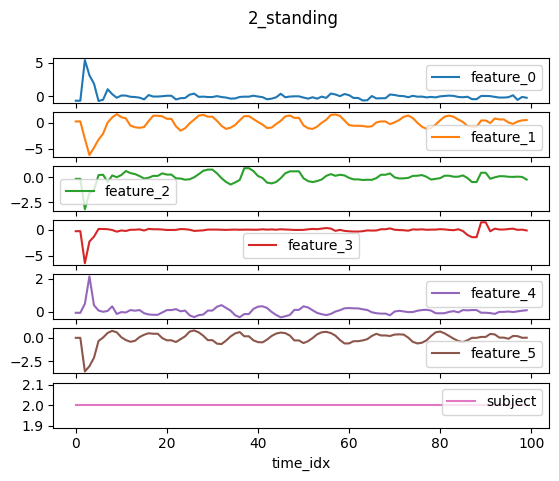

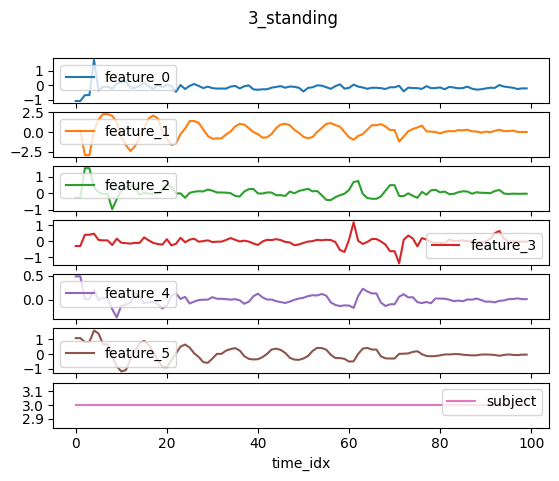

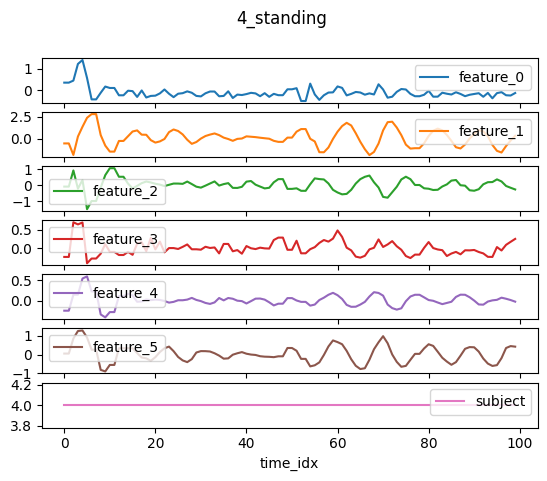

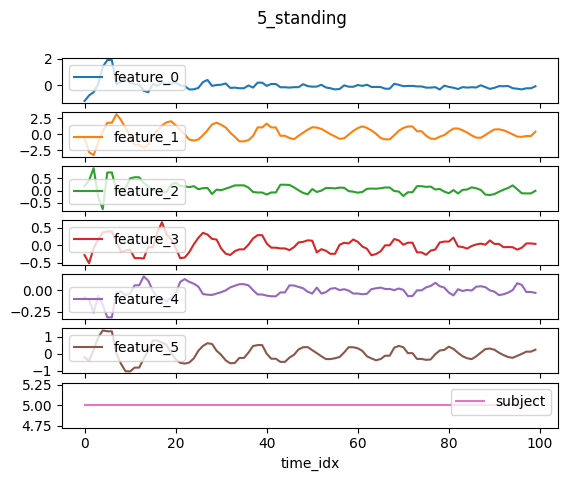

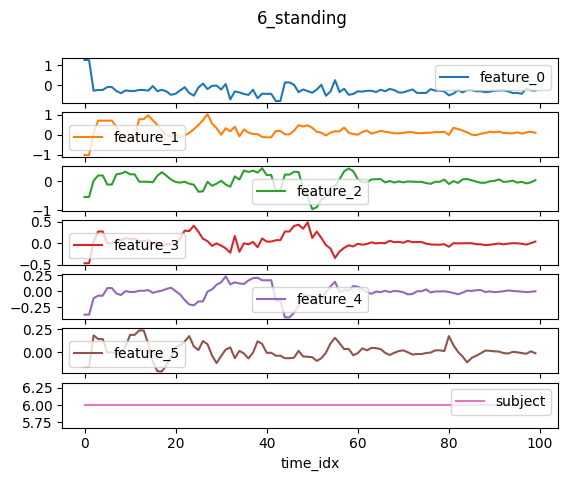

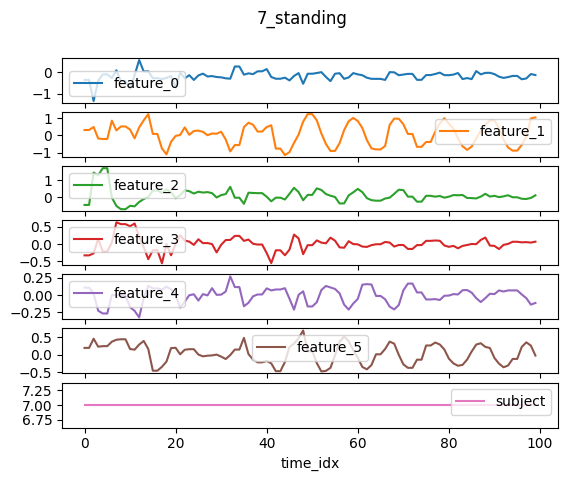

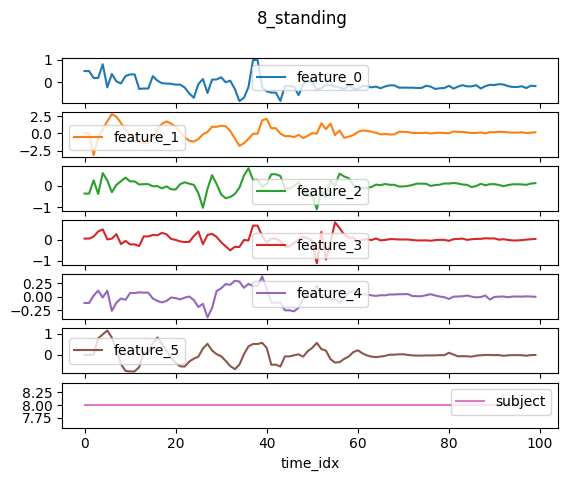

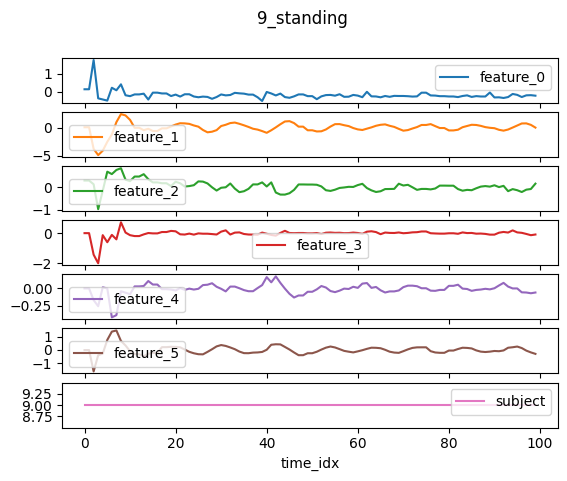

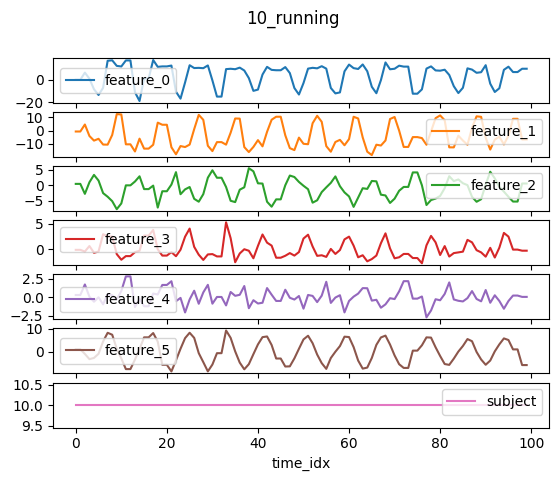

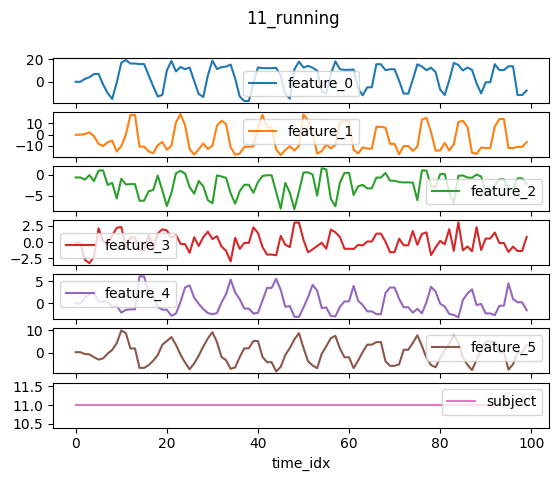

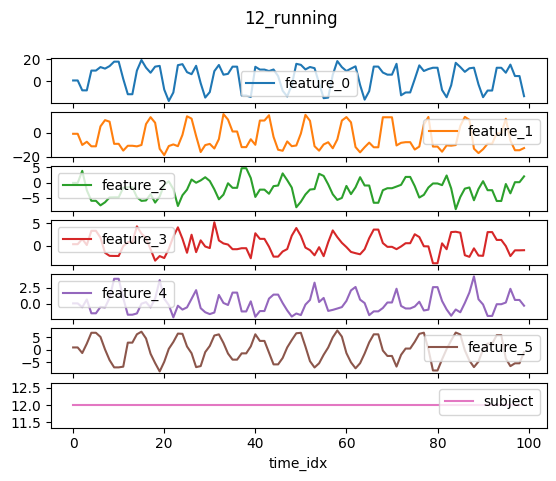

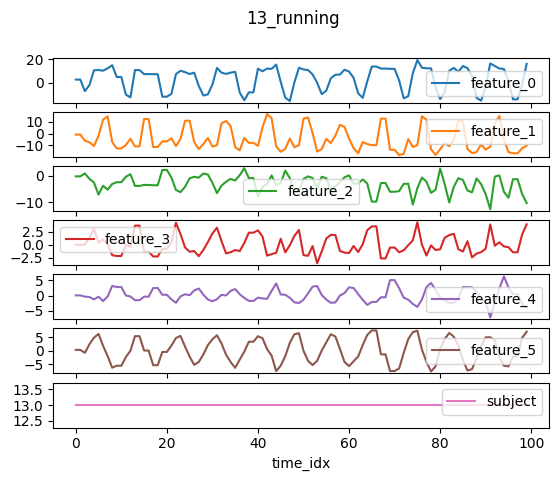

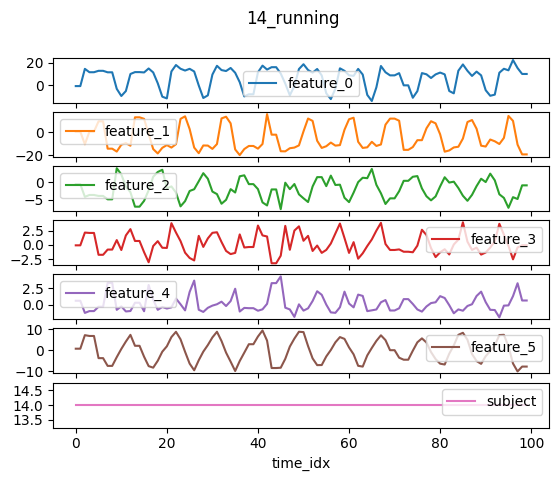

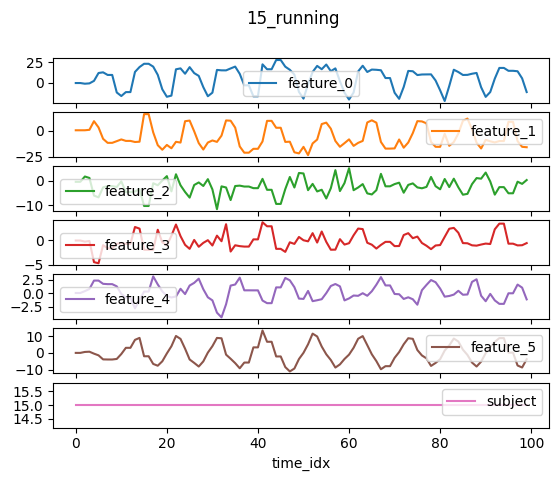

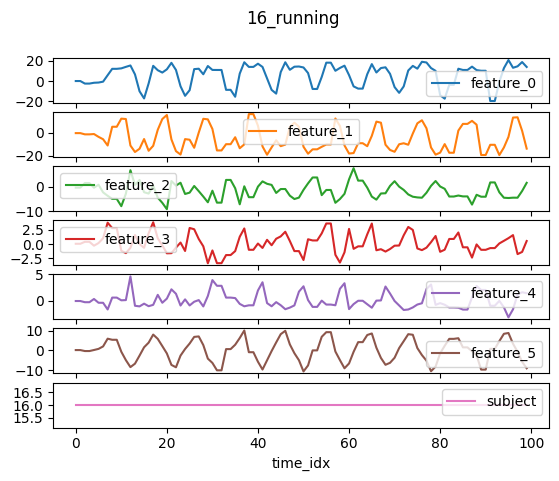

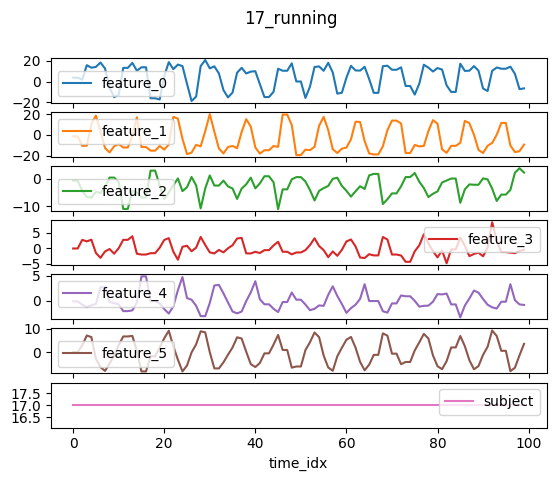

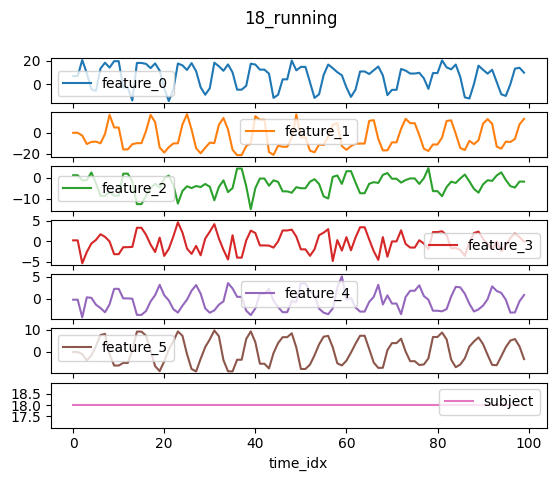

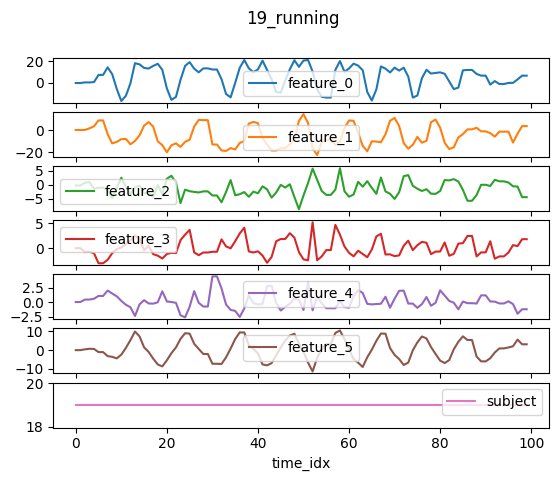

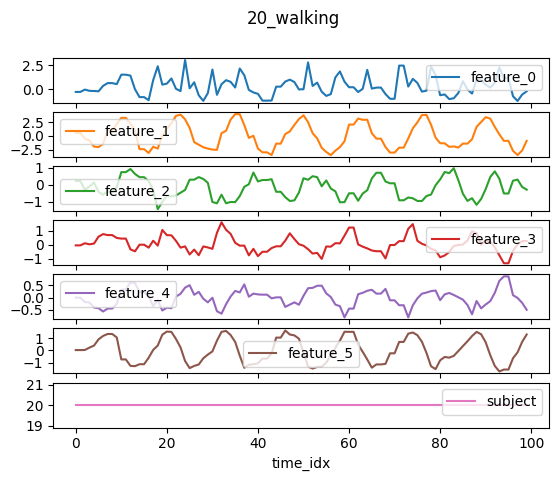

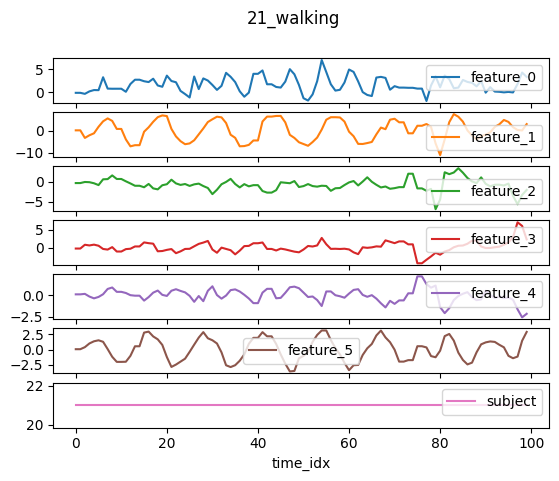

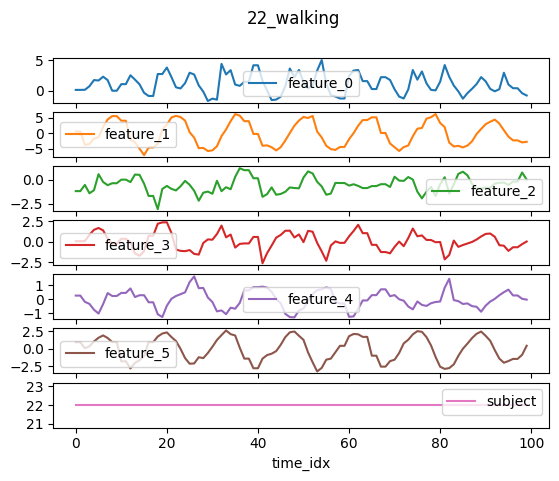

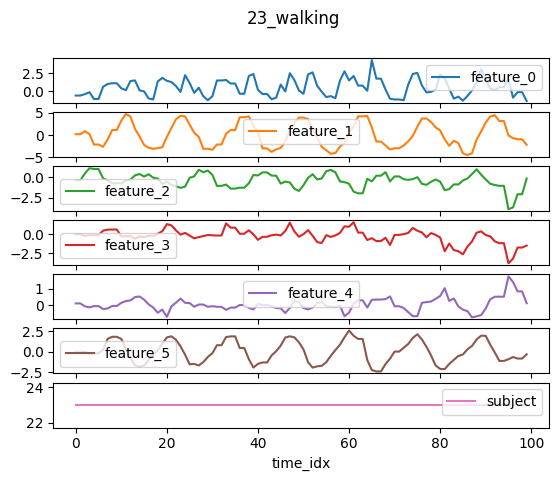

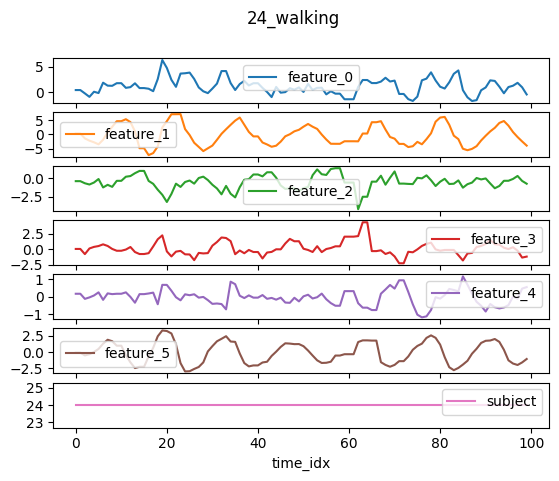

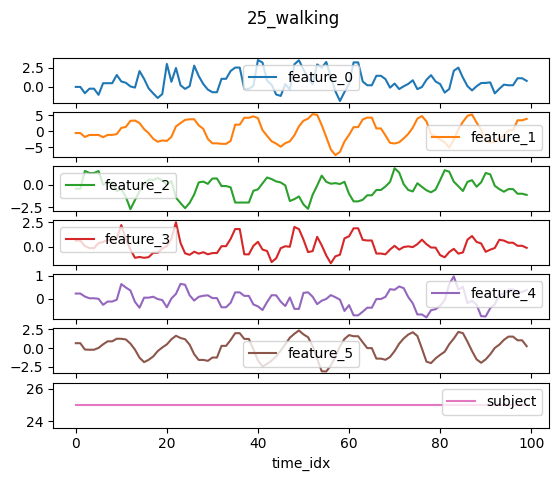

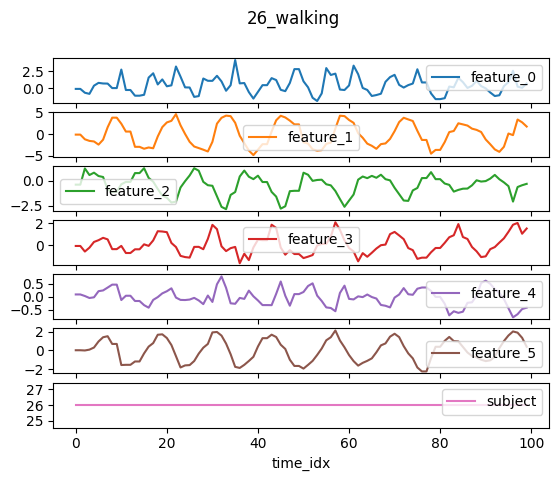

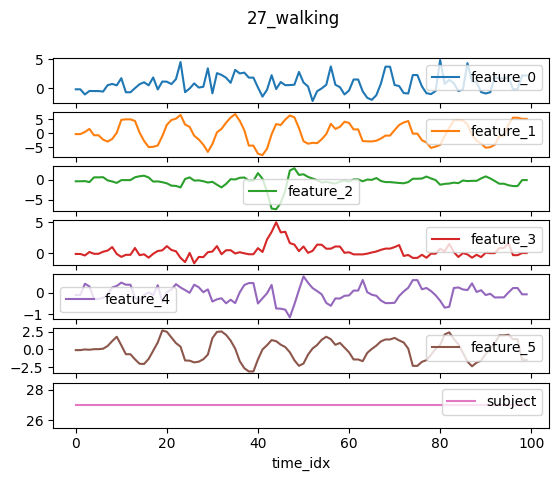

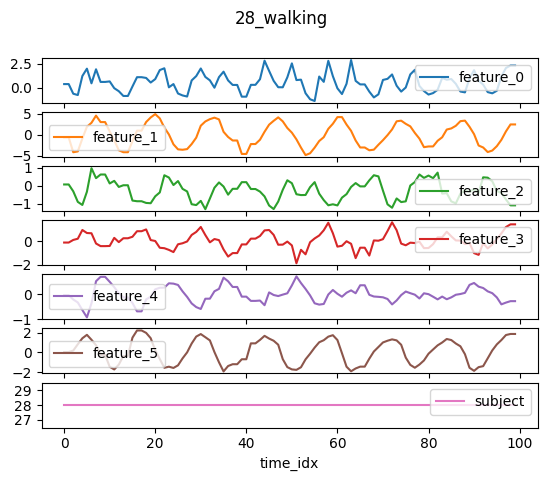

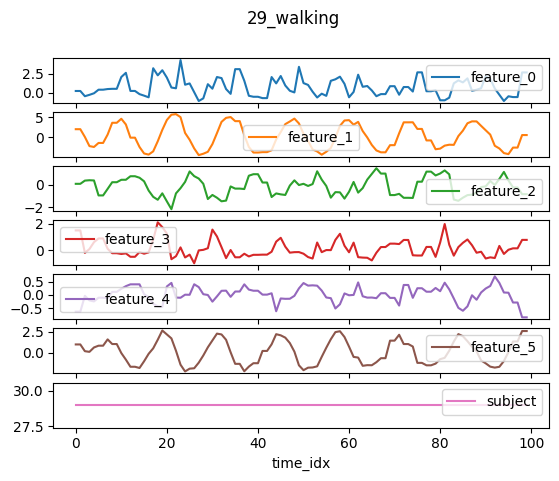

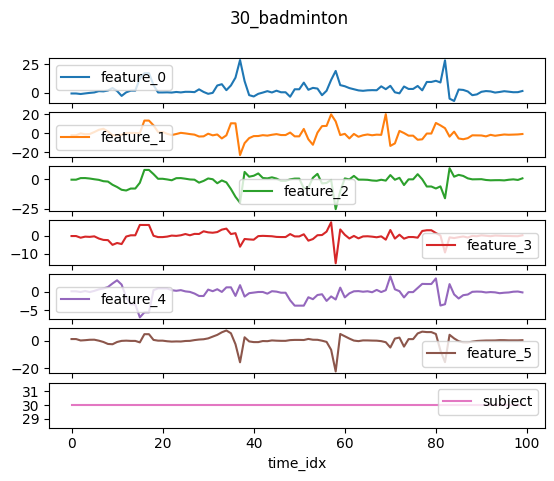

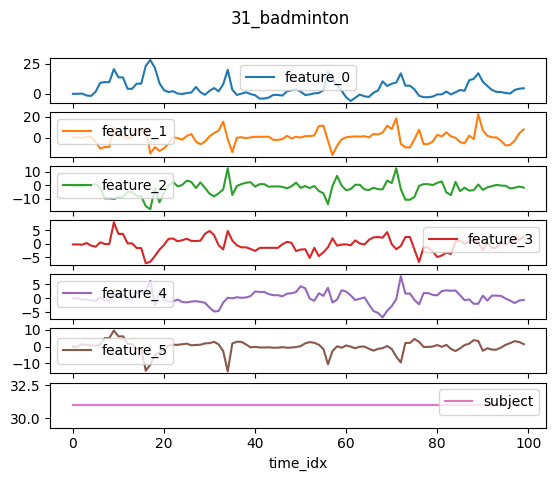

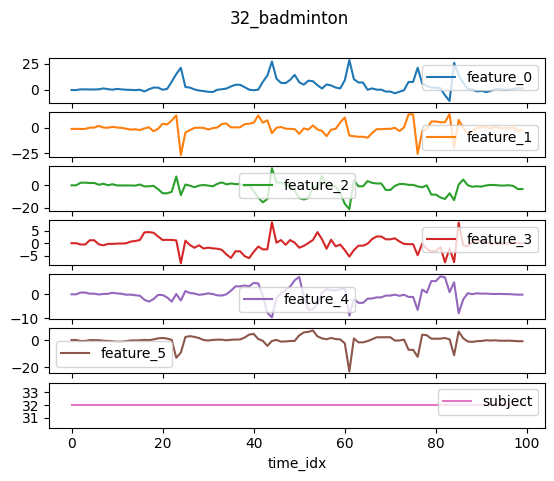

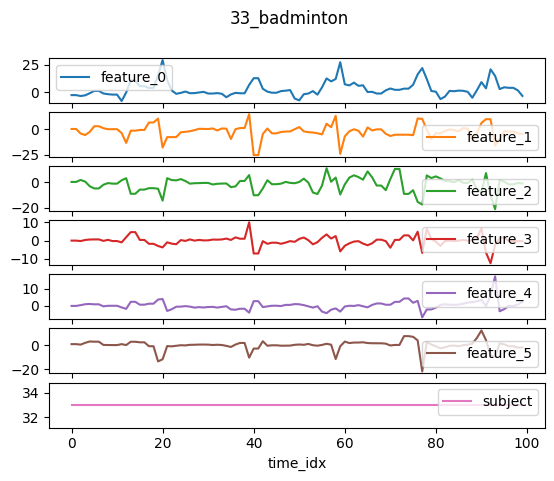

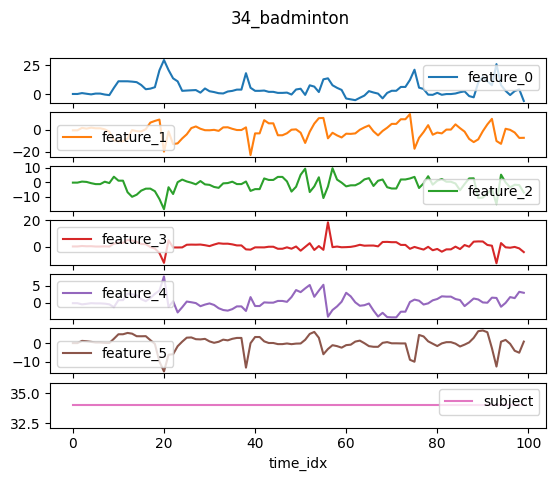

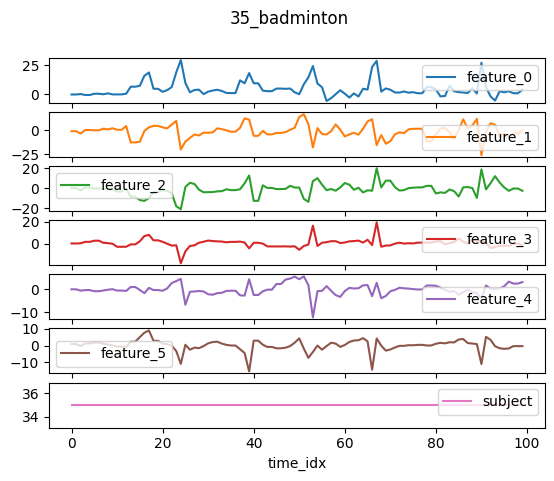

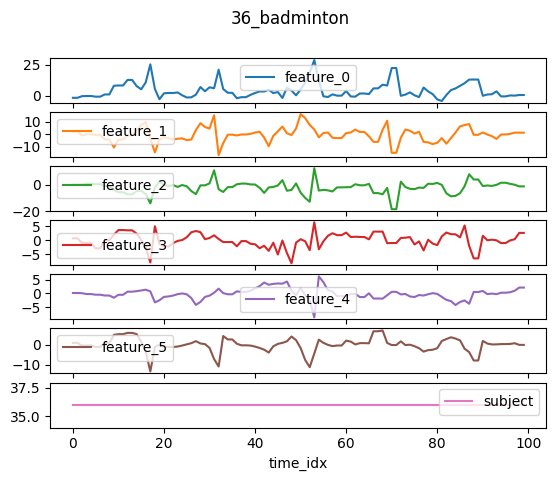

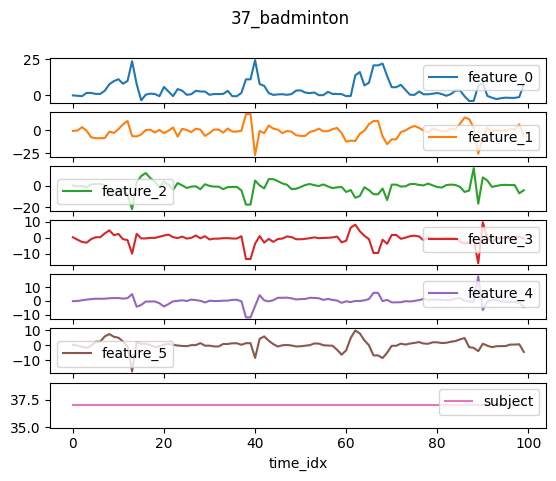

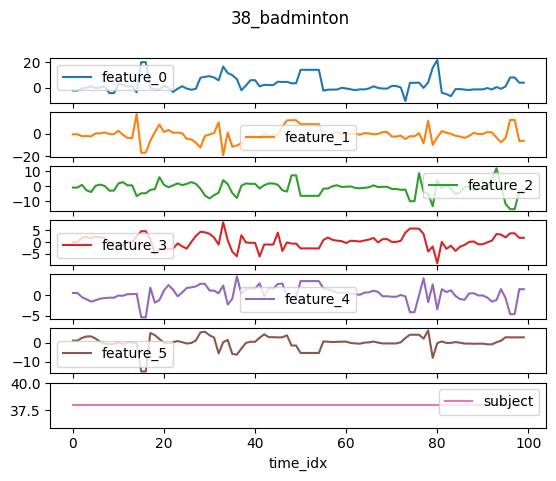

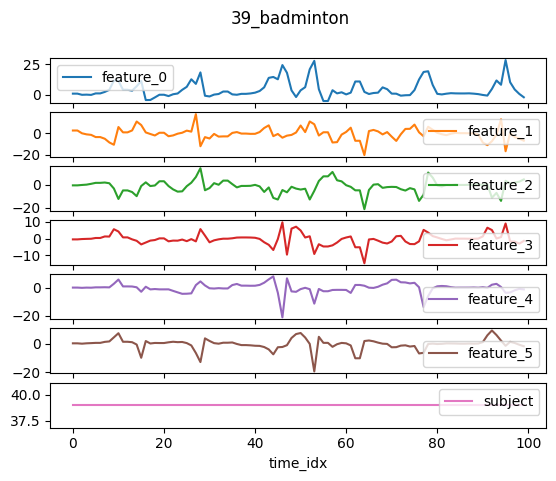

In [14]:
import random

# plt.style.use('fivethirtyeight')
# test_df.set_index('time_idx').groupby(group_ids).plot(subplots=True, title='motion')
groups = test_df.set_index("time_idx").groupby(group_ids)
for group_name, group in groups:
    # print(group_name)
    group.plot(subplots=True, title='_'.join([str(s) for s in group_name]))